In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from torch import nn
import os
import zipfile

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Define zip filenames and their target folders
zip_mappings = {
    "zipped-train-healthy.zip": "train/healthy",
    "zipped-train-sick.zip": "train/sick",
    "test-healthy.zip": "test/healthy",
    "test-sick.zip": "test/sick"
}

In [ ]:
# Make sure each folder exists and unzip into it
for zip_name, target_dir in zip_mappings.items():
    os.makedirs(target_dir, exist_ok=True)
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(target_dir)

print("✅ All datasets unzipped and organized.")

✅ All datasets unzipped and organized.


In [ ]:
!pip install -q albumentations

In [ ]:
import albumentations as A
import cv2
from glob import glob
import os
from tqdm import tqdm

# Define original and augmented folder paths
original_train = "train"
augmented_train = "train_augmented"

os.makedirs(f"{augmented_train}/healthy", exist_ok=True)
os.makedirs(f"{augmented_train}/sick", exist_ok=True)

# Define augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.Resize(224, 224, p=1.0)
])

# Augment images
def augment_class_images(class_name):
    input_paths = glob(f"{original_train}/{class_name}/*.jpg")
    for img_path in tqdm(input_paths, desc=f"Augmenting {class_name}"):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        base_name = os.path.basename(img_path).split('.')[0]
        for i in range(3):  # generate 3 versions
            aug_img = augment(image=img)['image']
            aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(f"{augmented_train}/{class_name}/{base_name}_aug{i}.jpg", aug_img)

# Run for both healthy and sick
augment_class_images("healthy")
augment_class_images("sick")

print("✅ Data augmentation completed. Images saved in /train_augmented/")


Augmenting sick: 100%|██████████| 700/700 [00:03<00:00, 229.95it/s]

✅ Data augmentation completed. Images saved in /train_augmented/


In [ ]:
import shutil
from glob import glob
import os

# Define original and augmented folders
original_train = "train"
augmented_train = "train_augmented"

# Ensure augmented folders exist
os.makedirs(f"{augmented_train}/healthy", exist_ok=True)
os.makedirs(f"{augmented_train}/sick", exist_ok=True)

# Function to copy original images to the augmented folder
def merge_original_with_augmented(class_name):
    src_paths = glob(f"{original_train}/{class_name}/*.jpg")
    for path in tqdm(src_paths, desc=f"Merging {class_name}"):
        filename = os.path.basename(path)
        dest_path = f"{augmented_train}/{class_name}/{filename}"
        shutil.copy(path, dest_path)

# Merge both classes
merge_original_with_augmented("healthy")
merge_original_with_augmented("sick")

print("✅ Merged original + augmented training images into /train_augmented/")


Merging sick: 100%|██████████| 700/700 [00:00<00:00, 4165.08it/s]

✅ Merged original + augmented training images into /train_augmented/


In [ ]:
import os

# Paths to each class
healthy_dir = "/content/train_augmented/healthy"
sick_dir = "/content/train_augmented/sick"

# Count files
num_healthy = len(os.listdir(healthy_dir))
num_sick = len(os.listdir(sick_dir))

print(f"🟢 Total healthy images: {num_healthy}")
print(f"🔴 Total sick images: {num_sick}")
print(f"📊 Total training images: {num_healthy + num_sick}")


🟢 Total healthy images: 2800
🔴 Total sick images: 2800
📊 Total training images: 5600


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
import torch
import numpy as np

# ⚠️ Do NOT use any transforms here
dataset = ImageFolder('/content/train_augmented')  # or your folder with healthy/sick
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Load ViT
from transformers import ViTFeatureExtractor, ViTModel
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
vit_model.eval().to(device)

# ViT Feature Extraction using raw image paths
all_features = []
all_labels = []

with torch.no_grad():
    for img_path, label in tqdm(dataset.imgs, desc="Extracting features"):
        img = Image.open(img_path).convert("RGB")  # Load as PIL

        inputs = feature_extractor(images=img, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = vit_model(**inputs)
        cls_token = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # [CLS] token

        all_features.append(cls_token)
        all_labels.append(label)


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Extracting features: 100%|██████████| 5600/5600 [01:02<00:00, 90.02it/s]


ViT


In [ ]:
# ✅ Reduce embedding dimensions using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=128)  # Try 64 or 256 depending on speed vs accuracy
X = pca.fit_transform(X)     # Now shape is [5600, 128]

In [ ]:
for img_path, label in tqdm(dataset.imgs):
    img = Image.open(img_path).convert("RGB")
    inputs = feature_extractor(images=img, return_tensors="pt")


100%|██████████| 5600/5600 [00:12<00:00, 434.00it/s]


 KDE plot, normalization needed??


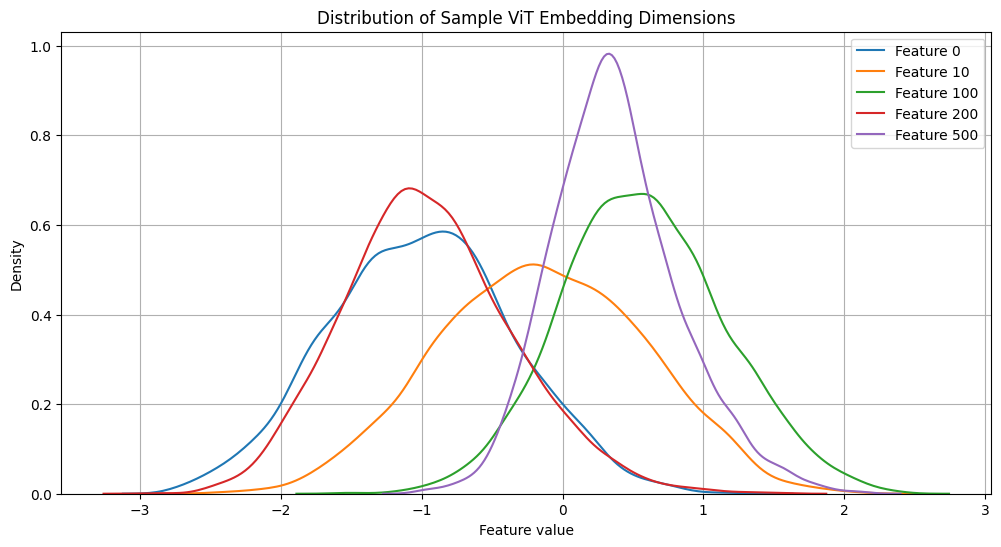

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all features
X = np.concatenate(all_features)

# Plot histogram of a few random feature dimensions
plt.figure(figsize=(12, 6))
for i in [0, 10, 100, 200, 500]:  # sample dimensions
    sns.kdeplot(X[:, i], label=f"Feature {i}")
plt.title("Distribution of Sample ViT Embedding Dimensions")
plt.xlabel("Feature value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Convert to NumPy if not already
X = np.concatenate(all_features)
y = np.array(all_labels)

# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

In [ ]:
# Dataloaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)

In [ ]:
!pip install -q pykan

In [ ]:
from kan import KAN
import torch.nn as nn
import torch.optim as optim

# Define KAN architecture: 768-dim input → 64 hidden → 2 output
kan_model = KAN(width=[128, 32, 2])
kan_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(kan_model.parameters(), lr=1e-3)

# Training loop
for epoch in range(5):
    kan_model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = kan_model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📘 Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


checkpoint directory created: ./model
saving model version 0.0
📘 Epoch 1, Loss: 0.6254
📘 Epoch 2, Loss: 0.4604
📘 Epoch 3, Loss: 0.3363
📘 Epoch 4, Loss: 0.2613
📘 Epoch 5, Loss: 0.2043


**Evaluate KAN on the validation set**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

kan_model.eval()
correct = 0
total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = kan_model(xb)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(yb.cpu().numpy())

accuracy = 100 * correct / total
print(f"✅ Validation Accuracy: {accuracy:.2f}%")

✅ Validation Accuracy: 90.09%


              precision    recall  f1-score   support

     healthy       0.92      0.88      0.90       560
        sick       0.88      0.93      0.90       560

    accuracy                           0.90      1120
   macro avg       0.90      0.90      0.90      1120
weighted avg       0.90      0.90      0.90      1120



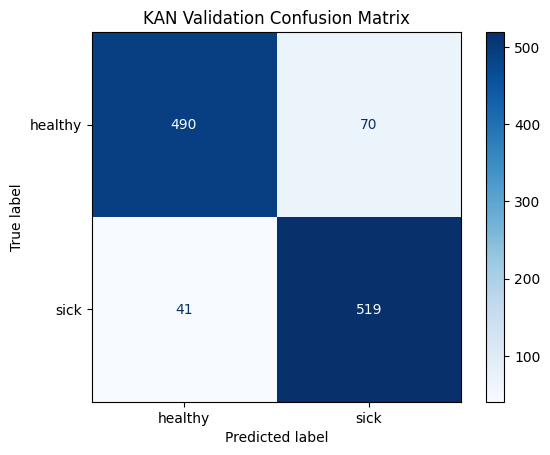

In [ ]:
# Classification report
print(classification_report(all_targets, all_preds, target_names=['healthy', 'sick']))

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['healthy', 'sick'])
disp.plot(cmap="Blues")
plt.title("KAN Validation Confusion Matrix")
plt.grid(False)
plt.show()

Load Pretrained ResNet-50 and Remove Final Layer

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm

# Load /test set (no transforms)
test_dataset = ImageFolder('/content/test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Extract CLS tokens using ViT
test_features = []
test_labels = []

with torch.no_grad():
    for path, label in tqdm(test_dataset.imgs, desc="Extracting test features"):
        img = Image.open(path).convert("RGB")
        inputs = feature_extractor(images=img, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = vit_model(**inputs)
        cls_token = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        test_features.append(cls_token)
        test_labels.append(label)

X_test = np.concatenate(test_features)
y_test = np.array(test_labels)


Extracting test features: 100%|██████████| 80/80 [00:00<00:00, 81.27it/s]


Function to Extract Embeddings from a DataLoader

In [ ]:
print(test_dataset.classes)  # ['healthy', 'sick']


['healthy', 'sick']


In [ ]:
print(test_dataset.class_to_idx)  # {'healthy': 0, 'sick': 1}


{'healthy': 0, 'sick': 1}


In [ ]:
# Use the same PCA model fitted earlier
X_test_reduced = pca.transform(X_test)  # shape: [N_test, 128]

# Convert to tensor
X_test_tensor = torch.tensor(X_test_reduced, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)


✅ Final Test Accuracy: 85.00%
              precision    recall  f1-score   support

     healthy       0.78      0.97      0.87        40
        sick       0.97      0.72      0.83        40

    accuracy                           0.85        80
   macro avg       0.87      0.85      0.85        80
weighted avg       0.87      0.85      0.85        80



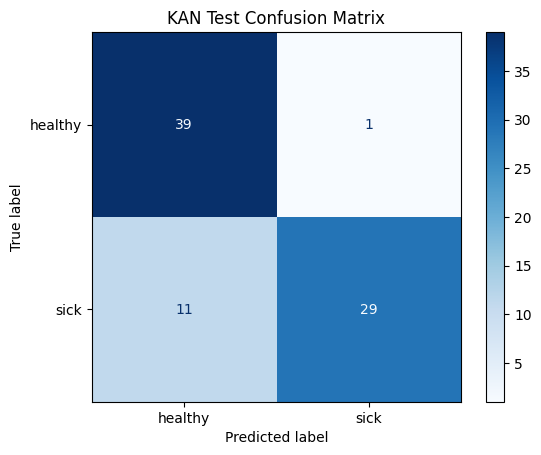

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

kan_model.eval()
correct = 0
total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = kan_model(xb)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(yb.cpu().numpy())

test_acc = 100 * correct / total
print(f"✅ Final Test Accuracy: {test_acc:.2f}%")
print(classification_report(all_targets, all_preds, target_names=test_dataset.classes))

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap="Blues")
plt.title("KAN Test Confusion Matrix")
plt.grid(False)
plt.show()


Extract Embeddings from Training and Test Sets

In [ ]:
torch.save(kan_model.state_dict(), "kan_final.pth")


In [ ]:
import gradio as gr
from PIL import Image
import torch
import numpy as np

# Reuse your feature extractor, PCA, and trained KAN
# Make sure kan_model.eval(), pca, and feature_extractor are still loaded

def predict_mri(image):
    # 1. Preprocess image
    img = image.convert("RGB")
    inputs = feature_extractor(images=img, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 2. ViT embedding
    with torch.no_grad():
        outputs = vit_model(**inputs)
        cls_token = outputs.last_hidden_state[:, 0, :].cpu().numpy()

    # 3. PCA reduction
    reduced = pca.transform(cls_token)

    # 4. KAN prediction
    input_tensor = torch.tensor(reduced, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = kan_model(input_tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

    # 5. Map index to label
    label_idx = np.argmax(probs)
    label_name = ['healthy', 'sick'][label_idx]

    return { "healthy": float(probs[0]), "sick": float(probs[1]) }

# Create the Gradio Interface
interface = gr.Interface(
    fn=predict_mri,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="Breast MRI Tumor Classifier",
    description="Upload a breast MRI image to classify it as healthy or sick using ViT + KAN."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e12b180f6d322ffd65.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
